# Raw Data Extraction

Creating dataset with images and labels from the pure set of videos and the json file.

In [1]:
from src.data import process_all_splits

In [2]:
VIDEO_ROOT = "C:\\Users\\sandr\\Downloads\\trailer\\trailer"
JSON_PATH = "C:\\Users\\sandr\\Downloads\\v1_split_trailer.json"
IMAGE_QUALITY = 15
OUTPUT_DIR = "./data"

In [ ]:
extrac_data = False
if extrac_data:
    process_all_splits(VIDEO_ROOT, JSON_PATH, IMAGE_QUALITY, OUTPUT_DIR) # took 1h and 8 minutes with ≈8frames/s

Extracting Frames: 100%|██████████| 33653/33653 [1:08:51<00:00,  8.15frame/s]


# Dataset Creation

In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from src.data import LensTypeDataset
from collections import Counter
from tqdm import tqdm
import os
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

noise_stds = [0.05, 0.1, 0.2, 0.4, 0.5]
noise_percentage = 0.3

train_dataset = LensTypeDataset(root_dir="./data", split="train", transform=transform_train,
                                noisy_percentage=noise_percentage, noise_stds=noise_stds, seed=SEED)
val_dataset = LensTypeDataset(root_dir="./data", split="val", transform=transform_val, noisy_percentage=0.0)
test_dataset = LensTypeDataset(root_dir="./data", split="test", transform=transform_val, noisy_percentage=0.0)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
print(f"Images in train: {len(train_dataset)}")
print(f"Images in val: {len(val_dataset)}")
print(f"Images in test: {len(test_dataset)}")
print(f"Total number of images: {len(test_dataset) + len(val_dataset) + len(train_dataset)}")

Images in train: 20856
Images in val: 4610
Images in test: 8187
Total number of images: 33653


In [5]:
print(f"Train label count: {Counter(train_dataset.labels)}")
print(f"Val label count: {Counter(val_dataset.labels)}")
print(f"Test label count: {Counter(test_dataset.labels)}")

Train label count: Counter({2: 4650, 1: 4529, 3: 4275, 0: 3946, 4: 3456})
Val label count: Counter({1: 1049, 2: 1006, 0: 922, 3: 886, 4: 747})
Test label count: Counter({1: 1792, 2: 1753, 3: 1642, 0: 1641, 4: 1359})


In [6]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])


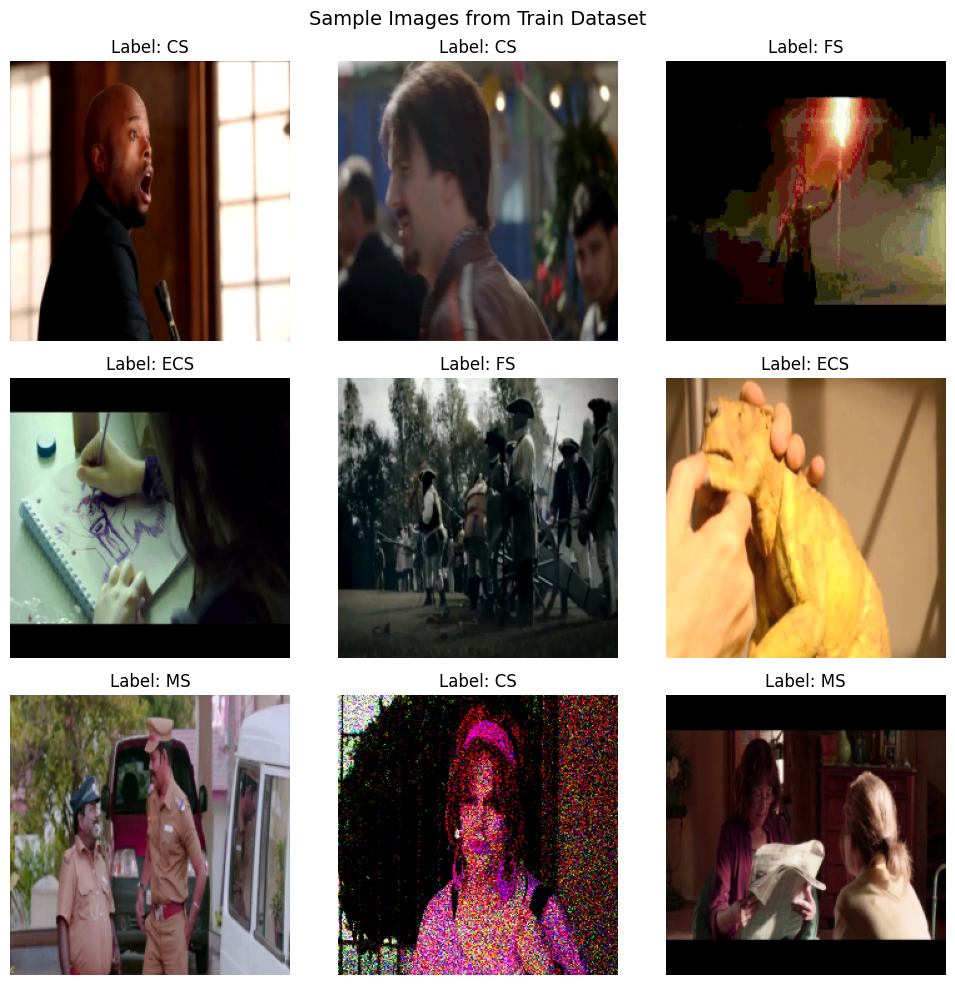

In [7]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample Images from Train Dataset", fontsize=14)

label_mapping = {0: "ECS", 1: "CS", 2: "MS", 3: "FS", 4: "LS"}

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()  # (C, H, W) to (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.set_title(f"Label: {label_mapping[labels[i].item()]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Fine-tuning

Now let's train the classifier, which we will use later for the guidance in the image generation. We'll use EfficientNetB3.

In [8]:
model = models.efficientnet_b3(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/users/eleves-a/2024/sandro.mikautadze/miniconda3/envs/optical-diffusion/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-a/2024/sandro.mikautadze/miniconda3/envs/optical-diffusion/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
in_feats = model.classifier[1].in_features # 1536
model.classifier = nn.Sequential(
    nn.Linear(in_feats, 512),
    nn.SiLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
)

for param in model.classifier.parameters():
    param.requires_grad = True

In [10]:
model = model.to(device)
# model

In [11]:
epochs = 5

def train_one_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    acc = correct / len(train_loader.dataset)
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {acc:.4f}")

    return avg_loss, acc

def validate(model, val_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    acc = correct / len(val_loader.dataset)
    print(f"Val Loss: {avg_loss:.4f}, Val Accuracy: {acc:.4f}")

    return avg_loss, acc

In [12]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

best_val_acc = 0
os.makedirs("checkpoints", exist_ok=True)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoints/lens_classifier_best_model.pth")
        print("Model Saved!")

print("Training Complete!")

Training Epoch 1/5: 100%|██████████| 326/326 [04:43<00:00,  1.15it/s]


Train Loss: 1.1359, Train Accuracy: 0.6085


Validating: 100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Val Loss: 0.9390, Val Accuracy: 0.7315
Model Saved!


Training Epoch 2/5: 100%|██████████| 326/326 [04:44<00:00,  1.15it/s]


Train Loss: 1.0503, Train Accuracy: 0.6437


Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Val Loss: 0.9308, Val Accuracy: 0.7338
Model Saved!


Training Epoch 3/5: 100%|██████████| 326/326 [04:42<00:00,  1.16it/s]


Train Loss: 1.0362, Train Accuracy: 0.6517


Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Val Loss: 0.9156, Val Accuracy: 0.7416
Model Saved!


Training Epoch 4/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]


Train Loss: 1.0211, Train Accuracy: 0.6638


Validating: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s]


Val Loss: 0.9085, Val Accuracy: 0.7505
Model Saved!


Training Epoch 5/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]


Train Loss: 1.0106, Train Accuracy: 0.6687


Validating: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s]

Val Loss: 0.9092, Val Accuracy: 0.7460
Training Complete!


In [ ]:
# RESULTS

# 1
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# ---
# Training Epoch 1/5: 100%|██████████| 326/326 [05:07<00:00,  1.06it/s]
# Train Loss: 0.9905, Train Accuracy: 0.6051
# Validating: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
# Val Loss: 0.7138, Val Accuracy: 0.7278
# Model Saved!
# Training Epoch 2/5: 100%|██████████| 326/326 [04:42<00:00,  1.15it/s]
# Train Loss: 0.8670, Train Accuracy: 0.6414
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]
# Val Loss: 0.7049, Val Accuracy: 0.7291
# Model Saved!
# Training Epoch 3/5: 100%|██████████| 326/326 [04:43<00:00,  1.15it/s]
# Train Loss: 0.8513, Train Accuracy: 0.6502
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.60it/s]
# Val Loss: 0.6835, Val Accuracy: 0.7425
# Model Saved!
# Training Epoch 4/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]
# Train Loss: 0.8341, Train Accuracy: 0.6590
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.60it/s]
# Val Loss: 0.6733, Val Accuracy: 0.7406
# Training Epoch 5/5: 100%|██████████| 326/326 [04:42<00:00,  1.15it/s]
# Train Loss: 0.8184, Train Accuracy: 0.6612
# Validating: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s]
# Val Loss: 0.6824, Val Accuracy: 0.7358
# Training Complete!

# 2
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # add label smoothing because in the end the shot type is not a so "discrete" model
# optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# ---
# Training Epoch 1/5: 100%|██████████| 326/326 [04:43<00:00,  1.15it/s]
# Train Loss: 1.1359, Train Accuracy: 0.6085
# Validating: 100%|██████████| 73/73 [00:46<00:00,  1.57it/s]
# Val Loss: 0.9390, Val Accuracy: 0.7315
# Model Saved!
# Training Epoch 2/5: 100%|██████████| 326/326 [04:44<00:00,  1.15it/s]
# Train Loss: 1.0503, Train Accuracy: 0.6437
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]
# Val Loss: 0.9308, Val Accuracy: 0.7338
# Model Saved!
# Training Epoch 3/5: 100%|██████████| 326/326 [04:42<00:00,  1.16it/s]
# Train Loss: 1.0362, Train Accuracy: 0.6517
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]
# Val Loss: 0.9156, Val Accuracy: 0.7416
# Model Saved!
# Training Epoch 4/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]
# Train Loss: 1.0211, Train Accuracy: 0.6638
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s]
# Val Loss: 0.9085, Val Accuracy: 0.7505
# Model Saved!
# Training Epoch 5/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]
# Train Loss: 1.0106, Train Accuracy: 0.6687
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s]
# Val Loss: 0.9092, Val Accuracy: 0.7460
# Training Complete!

# Testing